# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pdb
from tqdm import tqdm

# I - Clustering algorithms

## Kmeans implementation

In [2]:
class Kmeans:
    
    # Kmeans++ initialization
    def init(self, X, n):
        (N, d) = X.shape
        P = np.empty((n, d))
        P[0] = X[np.random.randint(0, N)]

        D = math.inf * np.ones(N)

        for i in range(n - 1):
            T = X - P[i]
            D = np.minimum(D, np.sum(T * T, axis=1))

            W = D.cumsum()

            z = np.random.uniform(0, W[-1])
            j = np.searchsorted(W > z, True)
            P[i + 1] = X[j]

        return P

    def __init__(self, X, n, max_iter = 100, restarts=10, e=0.1):
        H_best = math.inf
        for i in range(restarts):
            (mu, Y, H, n_iter) = self.run(X, n, max_iter, e)
            if (H < H_best):
                H_best = H
                self.mu = mu
                self.Y = Y
                self.H = H
                self.n_iter = i
        

    def _assign(self, X, mu):

        D = X[:, None, :] - mu[None, :, :]
        D = np.sum(D * D, axis=2)

        Y = np.argmin(D, axis=1)
        H = np.sum(np.min(D, axis=1))
        
        return (Y, H)
        
            
    def run(self, X, n, max_iter = 100, e = 0.1):
        (N, d) = X.shape;

        mu = self.init(X, n)
        #mu = X[np.random.choice(N, n, replace=False)]

        for i in range(max_iter):

            (Y, H) = self._assign(X, mu)
            
            Z = np.zeros((N, d))
            Z[np.arange(N), Y] = 1

            old_mu = mu
            mu = Z.T.dot(X) / Z.sum(axis = 0)[:,None]

            if (np.max(mu - old_mu) < e):
                break

        (Y, H) = self._assign(X, mu)
                
        return (mu, Y, H, i)

## Spectral clustering

In [4]:
from sklearn.cluster import KMeans

eps = 0.0001

def SC(W, n):
    
    D = np.sum(W, axis=1)
    L = np.diag(D) - W
    _, e = np.linalg.eigh(L)
    Y = e[:, :n]

    # Uncomment to use my version of Kmeans
    #kmeans = Kmeans(Y, n)
    #return kmeans.Y

    kmeans = KMeans(n)
    return kmeans.fit_predict(Y)


def NSC(W, n):
    
    Dn = np.diag(1.0 / (np.sqrt(np.sum(W, axis=1)) + eps))
    Wn = np.dot(Dn, np.dot(W, Dn))
    
    L = np.identity(len(Wn)) - Wn
    v, e = np.linalg.eigh(L)
    Y = e[:, :n]
    
    # Uncomment to use my version of Kmeans
    # kmeans = Kmeans(Y, n)
    # return kmeans.Y

    kmeans = KMeans(n)
    return kmeans.fit_predict(Y)

## K subspaces

In [5]:
from sklearn.utils.extmath import randomized_svd
from scipy.linalg import qr

class Ksubspaces_v1:

    def ortho_matrix(self, D, d):
#         H = np.random.randn(D, D)
#         Q, R = qr(H)
#         return Q[:, :d]
        return np.linalg.svd(np.random.randn(D, d), False)[0]
        
    def init_naive(self, X, n):
        N, D = X.shape
        P = X[np.random.choice(N, n, False)]
        return P
    
    # Gaussian initialization
    def init_gaussian(self, X, n):
        
        mu = np.mean(X, axis=0)
        sigma = np.cov(X.T)
        P = np.random.multivariate_normal(mu, sigma, n)
        
        return P
    
    # Kmeans++ initialization
    def init_kmeanspp(self, X, n):
        (N, d) = X.shape
        P = np.empty((n, d))
        P[0] = X[np.random.randint(0, N)]

        D = math.inf * np.ones(N)

        for i in range(n - 1):
            T = X - P[i]
            D = np.minimum(D, np.sum(T * T, axis=1))

            W = D.cumsum()

            z = np.random.uniform(0, W[-1])
            j = np.searchsorted(W > z, True)
            P[i + 1] = X[j]

        return P
    
    
    
    def __init__(self, X, d, max_iter=100, restarts=1):
        
        H_best = math.inf
        for i in range(restarts):
            (mu, U, Y, H, n_iter) = self.run(X, d, max_iter)
            if (H < H_best):
                H_best = H
                self.mu = mu
                self.U = U
                self.Y = Y
                self.H = H
                self.n_iter = i

    def _assign(self, X, mu, U, d):
        N, D = X.shape

        W = np.empty((len(d), N))
        for i in range(len(d)):
            
            Xc = X - mu[i]
            R = Xc - np.dot(np.dot(Xc, U[i]), U[i].T)
            W[i] = np.sum(R * R, axis=-1)
                        
        Y = np.argmin(W, axis=0)
        J = np.sum(np.min(W, axis=0))
            
        return (Y, J)
        
    def run(self, X, d, max_iter=100):
        N, D = X.shape

        #Initialization
        U = [self.ortho_matrix(D, di) for di in d]
#         U  = [np.linalg.svd(np.random.randn(D, di), False)[0] for di in d]
        mu = self.init_naive(X, len(d))
        #mu = self.init_gaussian(X, len(d))

        for i in range(max_iter):
            # Segmentation
            (Y, J) = self._assign(X, mu, U, d)

            #Estimation
            for j in range(len(d)):
                mu[j] = np.mean(X[Y == j], axis=0)
                R = (X[Y == j, :] - mu[j])
                # Uj, _, _ =  np.linalg.svd(R.T, full_matrices=False)
                #U[j] = Uj[:, :d[j]]
                U[j], _, _ =  randomized_svd(R.T, d[j])

        Y, J = self._assign(X, mu, U, d)
        
        return (mu, U, Y, J, i)



## Sparse subspace clustering with noisy data (SSC)

In [21]:
def shrinkage_thresholding(X, mu):
    return np.maximum(np.abs(X) - mu, 0) * np.sign(X)

# Victor's function
def getTau(X):
    M = np.dot(X, X.T)
    M = M - np.diag(np.diag(M))
    return 1/min(np.max(M, axis = 1))

class _SSC:
    
    def __init__(self, X, mu, tau, max_iter, eps):
        (N, D) = X.shape
        
        #Initialization
        C = np.zeros((N, N))
        L = np.zeros((N, N))
        
        #Precompute tau X^T X
        A = tau * np.dot(X, X.T)
        B = np.linalg.inv(A + mu * np.identity(N))
        
        for i in range(max_iter):

            Z = np.dot(B, A + mu * C - L)
            C = shrinkage_thresholding(Z + L / mu, 1 / mu)
            np.fill_diagonal(C, 0)
            L = L + mu * (Z - C)
            
            if np.max(np.abs(Z - C)) < eps:
                break;
        
            #print(np.max(np.abs(X.T - np.dot(X.T, C))))
            #print(np.sum(C != 0))
        self.C = C
        
class SSC_noisy:
    
    
    def __init__(self, X, n, mu, tau, max_iter=300, eps=1e-4):
        
        ssc = _SSC(X, mu, tau, max_iter, eps)
        C = ssc.C
                
        C = np.abs(C)
        C /= np.max(C, axis=1) + eps
        
        W = C + C.T 
        
        self.Y = NSC(W, n)
            

## K nearest neighbor gaussian affinity

In [22]:
from sklearn.neighbors import NearestNeighbors

def gaussian_knn_affinity(X, k, sqsigma):
    
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='sqeuclidean').fit(X)
    W = nbrs.kneighbors_graph(X, mode='distance').toarray()
    W[W.nonzero()] = np.exp(- W[W.nonzero()] / (2 * sqsigma))
    W = W + W.T
    return W
    

## Clustering error

In [23]:
from scipy.optimize import linear_sum_assignment

def clustering_error(labels, groups):
    m = max(np.max(labels), np.max(groups)) + 1
    w = np.bincount(labels * m + groups, minlength=m*m)
    w = w.reshape((m, m))
    r, c = linear_sum_assignment(np.max(w) - w) # Kuhn-Munkres
    return np.mean(c[labels] != groups)


# Testing the algorithms on 3D lines

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Generation of the lines

In [25]:
n = 2
sqsigma = 10.0

N1 = 100
u1 = np.array([1, 0, 1])
b1 = np.array([1, 1, 1])
p1 = u1[None,:] * np.random.uniform(-2, 2, N1)[:, None] + b1

N2 = 100
u2 = np.array([-1, 1, 0])
b2 = np.array([-1, -1, -1])
p2 = u2[None,:] * np.random.uniform(-2, 2, N2)[:, None] + b2

X = np.vstack((p1, p2))

## K subspaces

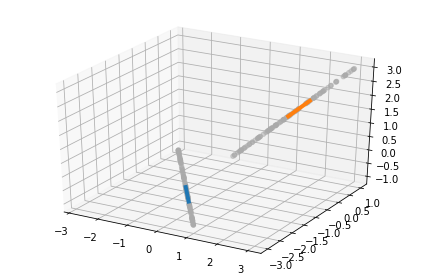

In [26]:
ksub = Ksubspaces_v1(X, [1, 1], max_iter=100, restarts=5)

x1 = np.c_[ksub.mu[0], ksub.mu[0] + np.squeeze(ksub.U[0])]
x2 = np.c_[ksub.mu[1], ksub.mu[1] + np.squeeze(ksub.U[1])]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X.T, color="#aaaaaa", alpha=0.5)
ax.plot(*x1, linewidth=4)
ax.plot(*x2, linewidth=4)
plt.tight_layout()
plt.show()

## Spectral clustering

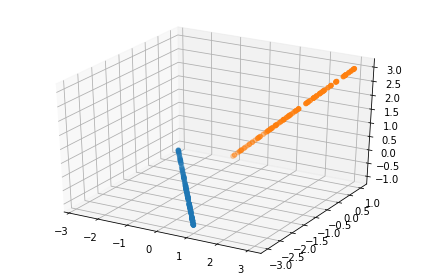

In [27]:
W = gaussian_knn_affinity(X, 8, sqsigma)
Y = SC(W, n)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X[Y == 0].T)
ax.scatter(*X[Y == 1].T)
plt.tight_layout()
plt.show()

## Sparse subspace clustering

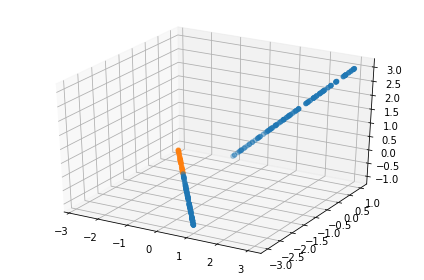

In [28]:
tau = 10 * getTau(X)
ssc = SSC_noisy(X, n, 40, tau)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X[ssc.Y == 0].T)
ax.scatter(*X[ssc.Y == 1].T)
plt.tight_layout()
plt.show()

# Testing the algorithms on faces

## Loading data

In [29]:
import scipy.io
 
extendedYaleB = scipy.io.loadmat('data/ExtendedYaleB.mat')

EYALEB_DATA = extendedYaleB['EYALEB_DATA']
EYALEB_LABEL = np.squeeze(extendedYaleB['EYALEB_LABEL'])

def extract_data(ind_ids):

    (data, labels) = (np.array([]).reshape(0, 2016), np.array([], dtype=int))

    for i, ind_id in enumerate(ind_ids):
        data = np.vstack((data, EYALEB_DATA[:, EYALEB_LABEL == ind_id].astype(float).T))
        labels = np.hstack((labels, i * np.ones(np.sum(EYALEB_LABEL == ind_id), dtype=int)))

    return data, labels

## Printing one face

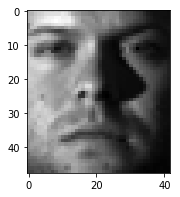

In [31]:
X, labels = extract_data(np.arange(1, 10))

plt.figure(figsize=(4, 3))
plt.imshow(X[19].reshape(42, 48).T, cmap="gray")
plt.show()

## Closest images to one image in the dataset

Using matplotlib backend: Qt5Agg


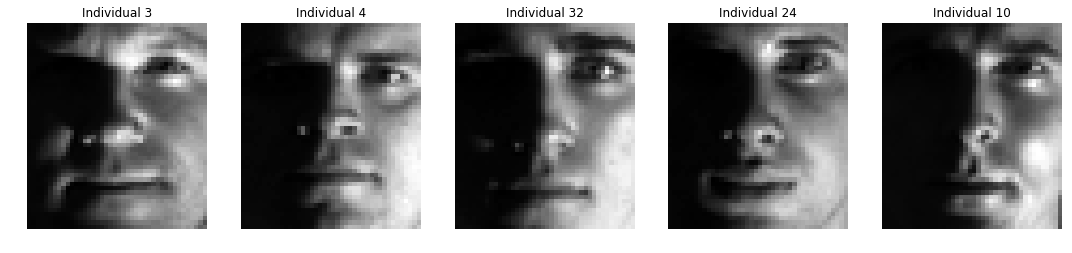

In [32]:
import matplotlib.pyplot as plt
%matplotlib

i = 177# Reference image
n = 5

D = np.sum((EYALEB_DATA - EYALEB_DATA[:, i][:, None]) ** 2, axis=0)
Y = np.argsort(D)[:n]

f, ax = plt.subplots(1, n, figsize=(3 * n, 4))
for i, y in enumerate(Y):
    ax[i].imshow(EYALEB_DATA[:, y].reshape(42, 48).T, cmap="gray")
    ax[i].axis("off")
    ax[i].set_title("Individual " + str(EYALEB_LABEL[y]))
plt.tight_layout()
plt.show()

## Cluster n individuals with SC

In [40]:
#Number of individuals
n = 2

X, labels = extract_data(np.arange(1, n + 1))

X /= np.linalg.norm(X, axis=1)[:, None]

W = gaussian_knn_affinity(X, 2, 0.4 * 0.4)
Y = SC(W, n)

print("Clustering error : ", clustering_error(Y, labels))

Clustering  0.0078125


## Cluster n individuals with K subspaces

In [41]:
#Number of individuals
n = 2

X, labels = extract_data(np.arange(1, n + 1))

ksub = Ksubspaces_v1(X, 3 * np.ones(n, dtype=int), max_iter=100, restarts=10)
print("Clustering error : ", clustering_error(ksub.Y, labels))

Clustering error :  0.0546875


## Cluster n individuals with SSC

In [42]:
#Number of individuals
n = 2

X, labels = extract_data(np.arange(1, n + 1))

ssc = SSC_noisy(X, n, 3000, 2.8e-5, 100)

print("Clustering error : ", clustering_error(ssc.Y, labels))

Clustering error :  0.0078125


## SC gradient

8it [00:33,  4.20s/it]


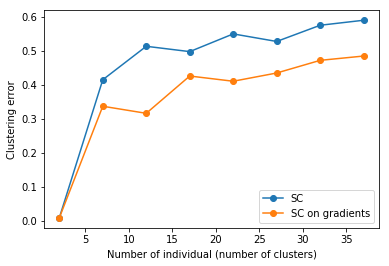

In [43]:
nrange = np.arange(2, 39, 5,dtype=int)

neighbors=2
sigma=0.4

sc_error = np.empty(len(nrange))
sc_grad_error = np.empty(len(nrange))

for i, n in tqdm(enumerate(nrange)):
    
    X, labels = extract_data(np.arange(1, n + 1))
    
    X1 = X / np.linalg.norm(X, axis=1)[:, None]

    W = gaussian_knn_affinity(X1, neighbors, sigma**2)
    Y = SC(W, n)
    sc_error[i] = clustering_error(Y, labels)
    
    X2 = np.reshape(X, (-1, 42, 48))
    X2 = np.roll(X, 1, -1) - np.roll(X, -1, -1)
    X2.reshape(-1, 42 * 48)
    
    X2 /= np.linalg.norm(X2, axis=1)[:, None]

    W = gaussian_knn_affinity(X2, neighbors, sigma**2)
    Y = SC(W, n)
    sc_grad_error[i] = clustering_error(Y, labels)

plt.figure(figsize=(6, 4))
plt.plot(nrange, sc_error, marker='o', label="SC")
plt.plot(nrange, sc_grad_error, marker='o', label="SC on gradients")
plt.ylabel("Clustering error")
plt.xlabel("Number of individual (number of clusters)")
plt.legend(loc='lower right')
plt.show()

# Varying the number of individuals

In [44]:
nrange = np.arange(3, 39, 5,dtype=int)

## SSC

In [45]:
mu=3000
tau=2.8e-5

ssc_error = np.empty(len(nrange))
for i, n in tqdm(enumerate(nrange)):
    
    X, labels = extract_data(np.arange(1, n + 1))
    ssc = SSC_noisy(X, n, mu, tau, 100)
    
    ssc_error[i] = clustering_error(ssc.Y, labels)

8it [02:03, 15.41s/it]


## SC

In [46]:
neighbors=2
sigma=0.4

sc_error = np.empty(len(nrange))
for i, n in tqdm(enumerate(nrange)):
    
    X, labels = extract_data(np.arange(1, n + 1))
    X /= np.linalg.norm(X, axis=1)[:, None]

    W = gaussian_knn_affinity(X, neighbors, sigma**2)
    Y = SC(W, n)
    sc_error[i] = clustering_error(Y, labels)

8it [00:18,  2.32s/it]


## K-subspaces

In [87]:
dim=3
restarts=5
max_iter=100

ksub_error = np.zeros(len(nrange))
for i, n in tqdm(enumerate(nrange)):
    
    X, labels = extract_data(np.arange(1, n + 1))

    ksub = Ksubspaces_v1(X, dim * np.ones(n, dtype=int), max_iter, restarts)
    ksub_error[i] = clustering_error(ksub.Y, labels)


0it [00:00, ?it/s]
5it [00:00, 46.75it/s]
7it [00:00, 24.67it/s]
8it [00:00, 19.03it/s]

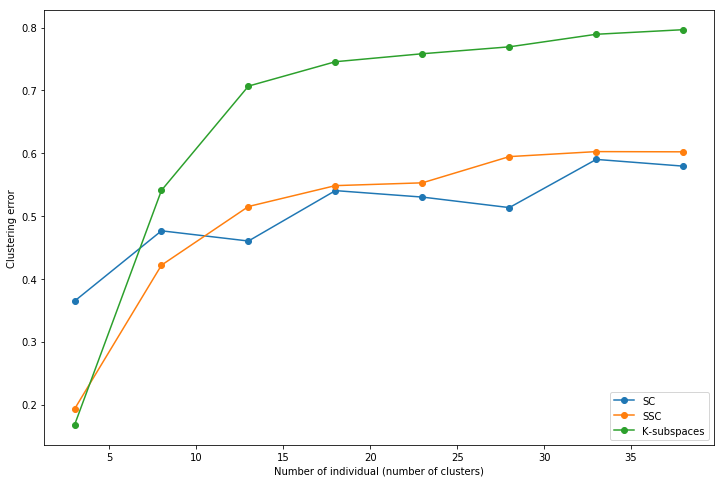

In [88]:
plt.figure(figsize=(12, 8))
plt.plot(nrange, sc_error, marker='o', label="SC")
plt.plot(nrange, ssc_error, marker='o', label="SSC")
plt.plot(nrange, ksub_error, marker='o', label="K-subspaces")
plt.ylabel("Clustering error")
plt.xlabel("Number of individual (number of clusters)")
plt.legend(loc='lower right')
plt.show()

## Ksubspaces variation of parameters

### Variation of dimensions

In [135]:
restarts=20
max_iter=100

X, labels = extract_data(np.arange(1, 2))

dimrange=[1, 2, 3, 4, 5, 6, 9, 12, 15, 20]

ksub_error_dim = np.zeros(len(dimrange))
for i, dim in tqdm(enumerate(dimrange)):

    ksub = Ksubspaces_v1(X, dim * np.ones(2, dtype=int), max_iter, restarts)
    ksub_error_dim[i] = clustering_error(ksub.Y, labels)

10it [02:48, 16.88s/it]


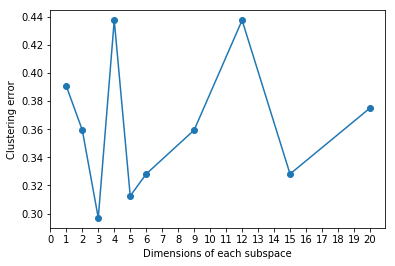

In [136]:
plt.figure()
plt.plot(dimrange, ksub_error_dim, marker='o')
plt.ylabel("Clustering error")
plt.xlabel("Dimensions of each subspace")
plt.xticks(np.arange(np.max(dimrange) + 1))
plt.show()

### Variation of restarts

In [124]:
dim=9
max_iter=100

X, labels = extract_data(np.arange(1, 2))

restartrange=[1, 2, 3, 5, 10, 15, 25, 50]

ksub_error_restarts = np.zeros(len(restartrange))
for i, restarts in tqdm(enumerate(restartrange)):

    ksub = Ksubspaces_v1(X, dim * np.ones(2, dtype=int), max_iter, restarts)
    ksub_error_restarts[i] = clustering_error(ksub.Y, labels)

8it [01:36, 12.04s/it]


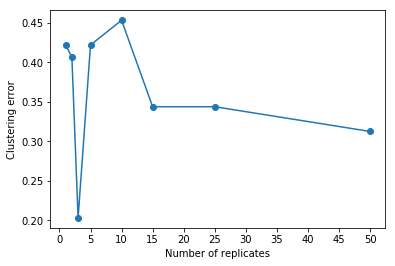

In [129]:
plt.figure()
plt.plot(restartrange, ksub_error, marker='o')
plt.ylabel("Clustering error")
plt.xlabel("Number of replicates")
plt.xticks(np.arange(0, np.max(restartrange) + 1, 5))
plt.show()

# Motion segmentation

In [121]:
import os
import scipy.io
import glob

data = []
labels = []
    
src_dir = 'data/hopkins'
for elt in tqdm(os.listdir(src_dir)):
    #print(elt)
    if os.path.isdir(os.path.join(src_dir, elt)):
        mat = scipy.io.loadmat(glob.glob(os.path.join(src_dir, elt, "*.mat"))[0])
        lab = mat['s'].reshape(-1)
        n = int(max(mat['s']))
        N = mat['x'].shape[1]
        F = mat['x'].shape[2]
        D = 2 * F
        
        labels.append(lab)
        data.append(np.transpose(mat['x'][:2,:,:], (2, 0, 1)).reshape(D, N))


100%|██████████| 158/158 [00:00<00:00, 425.13it/s]


In [55]:
sc_errors = []
for X, Y in tqdm(zip(data, labels)):
    n = np.max(Y)
    X /= np.linalg.norm(X, axis=0)
    Aff = gaussian_knn_affinity(X.T, 8, 1) # k-NN = 8, sigma = 1
    sc_errors.append(clustering_error(Y, SC(Aff, n)))

156it [00:03, 41.56it/s]


In [47]:
ssc_errors = []
for X, Y in tqdm(zip(data, labels)):
    n = np.max(Y)
    tau = 10 * getTau(X)
    ssc = SSC_noisy(X.T, n, 10, tau)
    ssc_errors.append(clustering_error(Y, ssc.Y))

156it [01:49,  1.43it/s]


In [122]:
ksub_errors = []
for X, Y in tqdm(zip(data, labels)):
    n = np.max(Y)
    ksub = Ksubspaces_v1(X.T, 3 * np.ones(n, dtype=int), 100, 5)
    ksub_errors.append(clustering_error(Y, ksub.Y))

156it [04:25,  1.70s/it]


In [123]:
print(np.median(sc_errors))
print(np.mean(sc_errors))

print(np.median(ssc_errors))
print(np.mean(ssc_errors))

print(np.median(ksub_errors))
print(np.mean(ksub_errors))
print(np.std(ksub_errors))

0.199914471433
0.202241183738
0.34495467448
0.312639057646
0.0379223580158
0.0991497220557
0.134386988433
